# Stochastic Variational Sparse Gaussian Process Classification (白色化あり)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

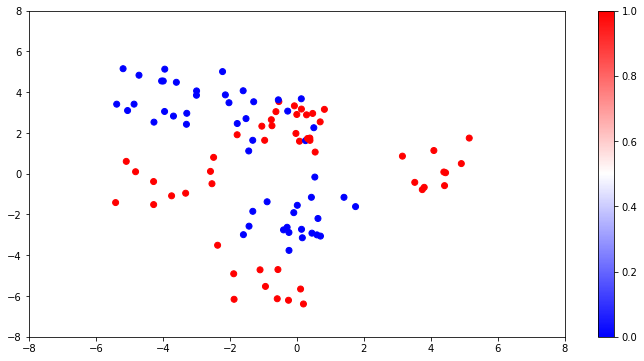

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    for batch_X, batch_y in dataloader:
        loss = svi.step(batch_X, batch_y, num_data = X.shape[0])
    if epoch % (n_epochs / 10) == 0:
        print(loss)

99.69763162372249
36.70316536631308
41.72802852461823
56.64854226161366
45.04187417320725
55.63542647435613
35.80260208487367
55.17684011622427
41.69040868843355
55.11002929170306


---

## 推論結果

### 予測分布

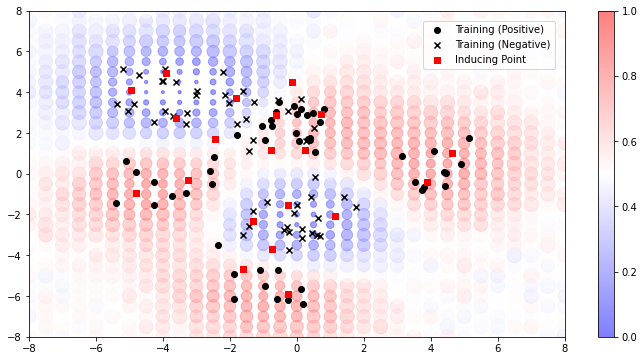

CPU times: user 24.7 s, sys: 1.28 s, total: 26 s
Wall time: 7.05 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.7636, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-0.6268,  2.9029],
        [-4.9552,  4.0982],
        [ 4.6430,  1.0321],
        [-0.7641,  1.1581],
        [-3.2361, -0.3288],
        [-3.6175,  2.7354],
        [-1.6167, -4.6724],
        [-0.2540, -1.5205],
        [ 0.7244,  2.9523],
        [-1.3177, -2.3221],
        [-0.1343,  4.5159],
        [-3.9022,  4.9195],
        [ 3.8957, -0.4219],
        [-1.8029,  3.7378],
        [-4.7989, -0.9226],
        [-2.4402,  1.6985],
        [-0.2621, -5.8857],
        [ 1.1503, -2.0757],
        [ 0.2525,  1.1477],
        [-0.7427, -3.7129]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 0.3045, -2.0051,  1.5129,  0.3117,  1.1723, -1.1436,  0.6912, -2.5554,
          1.0979, -0.5293, -0.4455, -0.7947,  0.7910, -0.6162,  0.6321, -0.3168,
          0.9514, -0.9120,  0.1789, -0.7562]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 2.4929e-01, -2.6270e-02, -2.8318e-02, -2.0203e-02, -5.7592e-02,
          -8.6421e-02,  1.1821e-03,  2.8157e-02, -5.4259e-02, -1.4022e-02,
          -3.8444e-02, -5.1423e-02,  1.9069e-02, -2.1131e-02,  1.4097e-02,
          -2.2417e-02, -4.3787e-02,  1.2358e-02, -1.0766e-02, -1.1165e-02],
         [-2.6270e-02,  3.5557e-01,  3.3828e-02,  3.2781e-02, -1.3541e-02,
          -1.1373e-01, -3.4719e-03,  3.7801e-02,  5.2101e-02,  3.5406e-02,
           3.4919e-02, -1.4379e-01, -5.6349e-02,  4.0824e-02,  2.1702e-02,
          -1.5428e-02,  6.3783e-02, -2.8176e-02,  7.9654e-04,  4.7578e-02],
         [-2.8318e-02,  3.3828e-02,  6.9479e-01,  6.4901e-03,  1.5495e-01,
          -2.9450e-02,  4.1716e-02,  1.1677e-01,  8.9476e-03, -4.6645e-02,
          -2.6420e-02,  4.5538e-02, -1.0284e-01,  6.8317e-02,  4.3035e-02,
           2.6478e-02,  4.0079e-02,  9.7330e-02, -2.1268e-02, -6.7432e-02],
         [-2.0203e-02,  3.2781e-02,  6.4901e-03,  4.6185e-01, -1.7025e-01,
           2.7343e-02,